<a href="https://colab.research.google.com/github/YoofKhaneja/Heart_Disease_Prediction/blob/master/Codes/Embedding_from_Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate Embeddings using Weights of Pre-Trained Network

### The weights Siamese network that was trained beforehand are used in a new single network to generate better embeddings of data. These new embeddings will then be used to train a new network.

## Importing the basic libraries

In [1]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Random seeding

In [0]:
from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(42)

## Loading the saved model and creating our new base network from it to generate embeddings

In [3]:
from keras import Model
from google.colab import drive

drive.mount('/content/gdrive')
save_path_model = 'gdrive/My Drive/Models/siamese_model.h5'

trained_model = tf.keras.models.load_model(save_path_model, compile = False)
base_model = trained_model.get_layer('model_1')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
base_model.compile(optimizer = 'Adam', loss = 'binary_crossentropy')
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 15)                0         
_________________________________________________________________
D1 (Dense)                   (None, 256)               4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
D2 (Dense)                   (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
Embeddings (Dense)           (None, 256)               65792     
Total params: 135,680
Trainable params: 135,680
Non-trainable params: 0
_________________________________________________________________


## Visualizing the weights of each layer

In [5]:
names = [weight.name for layer in base_model.layers for weight in layer.weights]
weights = base_model.get_weights()

for name, weight in zip(names, weights):
    print(name, weight)

D1/kernel:0 [[ 0.00729344  0.05832239  0.00564845 ... -0.00913493 -0.15176642
  -0.10165922]
 [ 0.1698643  -0.05966703 -0.04480035 ...  0.02228253 -0.09405444
  -0.11436351]
 [ 0.17087613  0.07797966 -0.1969061  ...  0.05221877 -0.16092853
   0.01638158]
 ...
 [-0.28775206  0.02708439 -0.15235236 ...  0.04096884 -0.02592358
   0.01935897]
 [-0.10952163 -0.14293598 -0.16736577 ... -0.34855786  0.1786514
  -0.08515897]
 [-0.12054189 -0.6956326  -0.31234565 ...  0.00789948  0.21210329
   0.07259376]]
D1/bias:0 [ 1.47604244e-02  7.50642596e-03  7.20001012e-02  7.42459344e-03
 -1.43134836e-02 -3.79690751e-02  1.60800755e-01  2.82109040e-03
  5.33856414e-02 -4.66869064e-02  4.64146174e-02 -2.40977108e-02
 -3.27881165e-02 -2.11722746e-01 -4.34356332e-02  7.31790289e-02
 -1.39102330e-02 -2.32165270e-02  0.00000000e+00 -1.82393566e-01
 -1.83642760e-01 -9.18589756e-02  8.07927549e-02  0.00000000e+00
  0.00000000e+00 -2.17179172e-02  7.13412538e-02  2.73949429e-02
  6.21993002e-03  1.10233337e-01

## Loading the data and preprocessing

In [6]:
url = 'https://raw.githubusercontent.com/YoofKhaneja/Heart_Disease_Prediction/master/Codes/framingham.csv'
hd = pd.read_csv(url)
print('Before preprocessing: ')
print(hd.isnull().sum())
hd.head()

Before preprocessing: 
male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [7]:
import random
from fancyimpute import IterativeImputer

hd.BPMeds = hd.BPMeds.fillna(0)
edu = [1, 2, 3, 4]
c = 0
for i in range(len(hd.education)):
    if hd.education[i] not in edu:
        t = random.randint(1, 4)
        hd.education[i] = t
hdi = pd.DataFrame(IterativeImputer().fit_transform(hd))
hdi.columns = hd.columns

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
hd_ = hdi.copy(deep = True)
hd_['age'] = pd.cut(hd_['age'], 
                    5, 
                    labels = [1, 2, 3, 4, 5])
hd_['cigsPerDay'] = pd.cut(hd_['cigsPerDay'], 
                           6, 
                           labels = [1, 2, 3, 4, 5, 6])
hd_['totChol'] = pd.cut(hd_['totChol'], 
                        13, 
                        labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
hd_['sysBP'] = pd.cut(hd_['sysBP'], 
                      10, 
                      labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
hd_['diaBP'] = pd.cut(hd_['diaBP'], 
                      8, 
                      labels = [1, 2, 3, 4, 5, 6, 7, 8])
hd_['BMI'] = pd.cut(hd_['BMI'], 
                    10, 
                    labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
hd_['heartRate'] = pd.cut(hd_['heartRate'], 
                          8, 
                          labels = [1, 2, 3, 4, 5, 6, 7, 8])
hd_['glucose'] = pd.cut(hd_['glucose'], 
                        15, 
                        labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

hd_['age'] = hd_['age'].apply(lambda x: round(x*0.2, 2))
hd_['education'] = hd_['education'].apply(lambda x: round(x*0.25, 2))
hd_['cigsPerDay'] = hd_['cigsPerDay'].apply(lambda x: round(x*0.16, 2))
hd_['totChol'] = hd_['totChol'].apply(lambda x: round(x*0.077, 2))
hd_['sysBP'] = hd_['sysBP'].apply(lambda x: round(x*0.1, 2))
hd_['diaBP'] = hd_['diaBP'].apply(lambda x: round(x*0.125, 2))
hd_['BMI'] = hd_['BMI'].apply(lambda x: round(x*0.1, 2))
hd_['heartRate'] = hd_['heartRate'].apply(lambda x: round(x*0.125, 2))
hd_['glucose'] = hd_['glucose'].apply(lambda x: round(x*0.067, 2))

In [9]:
print('After preprocessing:')
print(hd_.isnull().sum())
hd_.head()

After preprocessing:
male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1.0,0.2,1.00,0.0,0.16,0.0,0.0,0.0,0.0,0.15,0.2,0.25,0.3,0.38,0.13,0.0
1,0.0,0.4,0.50,0.0,0.16,0.0,0.0,0.0,0.0,0.31,0.2,0.38,0.4,0.62,0.13,0.0
2,1.0,0.6,0.25,1.0,0.32,0.0,0.0,0.0,0.0,0.31,0.3,0.38,0.3,0.38,0.13,0.0
3,0.0,0.8,0.75,1.0,0.48,0.0,0.0,1.0,0.0,0.23,0.4,0.50,0.4,0.25,0.20,1.0
4,0.0,0.4,0.75,1.0,0.32,0.0,0.0,0.0,0.0,0.31,0.3,0.50,0.2,0.50,0.13,0.0


## Splitting the data into attributes and labels to generate embeddings

In [0]:
x = hd_.iloc[:, :-1]
y = hd_.iloc[:, -1]

## Generating the new embeddings

In [0]:
pred = base_model.predict(x)

In [0]:
x = pred

In [13]:
x[0]   # Classified as 0

array([0.        , 0.13305795, 0.        , 0.11891481, 0.        ,
       0.12382513, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.11084447, 0.        , 0.13123429,
       0.        , 0.12455659, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.11921414, 0.        , 0.        ,
       0.        , 0.11872975, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.1236831 , 0.        , 0.1337252 , 0.        , 0.        ,
       0.12879127, 0.13245589, 0.        , 0.        , 0.        ,
       0.        , 0.12222541, 0.        , 0.        , 0.        ,
       0.11798927, 0.        , 0.13285375, 0.        , 0.13706264,
       0.        , 0.        , 0.        , 0.12832958, 0.        ,
       0.12142015, 0.12055948, 0.        , 0.1215591 , 0.        ,
       0.        , 0.        , 0.        , 0.13400523, 0.        ,
       0.        , 0.1178892 , 0.        , 0.        , 0.     

In [14]:
x[6]   # Classified as 1

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## Calculating euclidean distance to see how good the new embeddings are

In [15]:
from scipy.spatial import distance
a = x[0] #0
b = x[3] #1
c = x[1] #0
d = x[6] #1
dst00 = distance.euclidean(a, c)
dst01 = distance.euclidean(a, b)
dst11 = distance.euclidean(b, d)
print([dst00, dst01, dst11])

[0.005198925267904997, 1.0065116882324219, 0.0]


## Using a simple, single-layered neural network to evaluate the embeddings

In [0]:
from keras import Sequential
from keras.layers import Dense, Activation

simple_classifier  = Sequential()

simple_classifier.add(Dense(1, input_dim = 256, activation = 'sigmoid'))
simple_classifier.compile(optimizer = 'Adam', loss = 'binary_crossentropy')

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits = 1, 
                             test_size = 0.2, 
                             random_state = 1)
attrib = np.array(x)
lab = np.array(y)
for train_index, test_index in sss.split(x, y):
    x_train, x_test = attrib[train_index], attrib[test_index]
    y_train, y_test = lab[train_index], lab[test_index]

## Evaluation and results

In [0]:
preds = simple_classifier.predict(x_test)
preds = (preds <= 0.5)

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, preds)
conf_matrix = pd.DataFrame(data = cm, 
                           columns = ['Predicted: 0', 'Predicted: 1'], 
                           index = ['Actual:0', 'Actual:1'])

print('Accuracy:', accuracy_score(y_test, preds))
conf_matrix

Accuracy: 0.9764150943396226


,Predicted: 0,Predicted: 1
Actual:0,713,6
Actual:1,14,115


In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       719
           1       0.95      0.89      0.92       129

    accuracy                           0.98       848
   macro avg       0.97      0.94      0.95       848
weighted avg       0.98      0.98      0.98       848



## Using SMOTE on the newly learned embeddings

In [21]:
from imblearn.over_sampling import SMOTE as smote
smt = smote()
x, y = smt.fit_sample(x, y)

from collections import Counter
cc = Counter(y)
print(cc[1])
print(cc[0])

3596
3596


In [0]:
sss = StratifiedShuffleSplit(n_splits = 1, 
                             test_size = 0.2, 
                             random_state = 1)
attrib = np.array(x)
lab = np.array(y)
for train_index, test_index in sss.split(x, y):
    x_train, x_test = attrib[train_index], attrib[test_index]
    y_train, y_test = lab[train_index], lab[test_index]

In [0]:
preds = simple_classifier.predict(x_test)
preds = (preds <= 0.5)

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, preds)
conf_matrix = pd.DataFrame(data = cm, 
                           columns = ['Predicted: 0', 'Predicted: 1'], 
                           index = ['Actual:0', 'Actual:1'])

print('Accuracy:', accuracy_score(y_test, preds))
conf_matrix

Accuracy: 0.9325920778318276


,Predicted: 0,Predicted: 1
Actual:0,713,6
Actual:1,91,629


In [25]:
print(classification_report(y_test, preds, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       719
           1       0.99      0.87      0.93       720

    accuracy                           0.93      1439
   macro avg       0.94      0.93      0.93      1439
weighted avg       0.94      0.93      0.93      1439



## Using the synthetically generated data, we build and train a new network for classification

In [26]:
from keras.layers import Dropout

model = Sequential()

model.add(Dense(2048, input_dim = 256)) 
model.add(Activation('relu', name = 'A1'))
model.add(Dropout(0.1))
model.add(Dense(2048, input_dim = 256)) 
model.add(Activation('relu', name = 'A2'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2048)              526336    
_________________________________________________________________
A1 (Activation)              (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
A2 (Activation)              (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2049      
__________

In [0]:
sss = StratifiedShuffleSplit(n_splits = 1, 
                             test_size = 0.2, 
                             random_state = 1)
attrib = np.array(x)
lab = np.array(y)
for train_index, test_index in sss.split(x, y):
    x_train, x_test = attrib[train_index], attrib[test_index]
    y_train, y_test = lab[train_index], lab[test_index]

In [0]:
def stats_avg(history, i):
    val_acc = np.array(history.history['val_acc'])
    val_loss = np.array(history.history['val_loss'])
    model_acc = np.array(history.history['acc'])
    model_loss = np.array(history.history['loss'])
    print('\n\nAverage validation loss:', val_loss.sum()/i)
    print('Average validation accuracy:', val_acc.sum()/i)
    print('Average loss:', model_loss.sum()/i)
    print('Average accuracy:', model_acc.sum()/i)
    print('\n')

def plots(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

Instructions for updating:
Use tf.cast instead.
Train on 4314 samples, validate on 1439 samples
Epoch 1/10
4314/4314 [==============================] - 1s 217us/step - loss: 0.4012 - acc: 0.8660 - val_loss: 0.2178 - val_acc: 0.9611
Epoch 2/10
4314/4314 [==============================] - 0s 65us/step - loss: 0.1481 - acc: 0.9692 - val_loss: 0.1322 - val_acc: 0.9694
Epoch 3/10
4314/4314 [==============================] - 0s 58us/step - loss: 0.1308 - acc: 0.9694 - val_loss: 0.1273 - val_acc: 0.9673
Epoch 4/10
4314/4314 [==============================] - 0s 61us/step - loss: 0.1276 - acc: 0.9685 - val_loss: 0.1322 - val_acc: 0.9666
Epoch 5/10
4314/4314 [==============================] - 0s 56us/step - loss: 0.1255 - acc: 0.9699 - val_loss: 0.1465 - val_acc: 0.9646
Epoch 6/10
4314/4314 [==============================] - 0s 56us/step - loss: 0.1318 - acc: 0.9669 - val_loss: 0.1332 - val_acc: 0.9673
Epoch 7/10
4314/4314 [==============================] - 0s 55us/step - loss: 0.1225 - acc: 0.

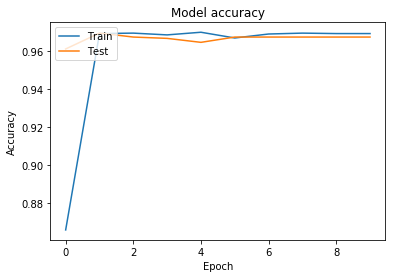

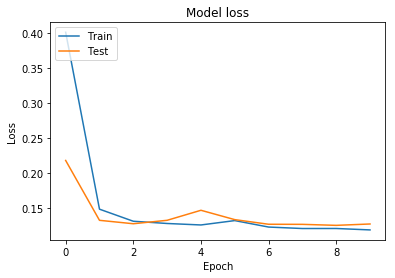

In [29]:
history = model.fit(x_train, y_train, 
          validation_split = 0.25, 
          batch_size = 256, 
          epochs = 10,
          verbose = 1)
stats_avg(history, i = 10)
plots(history)

In [30]:
evaluation = model.evaluate(x_train, y_train)
print('Loss:', evaluation[0])
print('Accuracy:', evaluation[1])

5753/5753 [==============================] - 0s 60us/step
Loss: 0.11863644933433258
Accuracy: 0.968885798620469


In [0]:
preds = model.predict(x_test)
preds = (preds >= 0.5)

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, preds)
conf_matrix = pd.DataFrame(data = cm, 
                           columns = ['Predicted: 0', 'Predicted: 1'], 
                           index = ['Actual:0', 'Actual:1'])

print('Accuracy:', accuracy_score(y_test, preds))
conf_matrix

Accuracy: 0.9555246699096595


,Predicted: 0,Predicted: 1
Actual:0,706,13
Actual:1,51,669


In [33]:
print(classification_report(y_test, preds, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       719
           1       0.98      0.93      0.95       720

    accuracy                           0.96      1439
   macro avg       0.96      0.96      0.96      1439
weighted avg       0.96      0.96      0.96      1439

